## Use k-Means clustering on economic, racial, age, district size, mean distance in voting behavior

- get dataframe from CSVs
- construct desired sets of predictors
- prepare labels
- run cluster algo
- encode clusters into existing data frame
- visual clusters
- identify cluster-defining properties

In [22]:
import pandas as pd
import numpy as np
from sklearn import cluster as skclust
from sklearn import preprocessing as skproc
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df = pd.read_csv("data/county_facts.csv")

In [24]:
rename_map={"PST045214": "Pop2014",
            "PST040210": "Pop2010EST",
            "PST120214": "Pop%Change",
            "POP010210": "Pop2010",
            "AGE135214": "Under5%",
            "AGE295214": "Under18%",
            "AGE775214": "Over65%",
            "SEX255214": "Female%",
            "RHI125214": "White%",
            "RHI225214": "Black%",
            "RHI325214": "NativeA%",
            "RHI425214": "Asian%",
            "RHI525214": "PIsland%",
            "RHI625214": "TwoRace%",
            "RHI725214": "Latino",
            "RHI825214": "WhiteNLat%",
            "POP715213": "SameHouse1yr%",
            "POP645213": "ForeignBorn%",
            "POP815213": "NonEnglish%",
            "EDU635213": "HighSchoolGrad%",
            "EDU685213": "Bachelor%",
            "VET605213": "Veteran",
            "LFE305213": "TravelTime",
            "HSG010214": "HousingUnits",
            "HSG445213": "OwnershipRate",
            "HSG096213": "UnitsinMultiUnit%",
            "HSG495213": "MedianValueHousing",
            "HSD410213": "Households",
            "INC910213": "PerCapitaIncome",
            "INC110213": "MedianIncome",
            "PVY020213": "%BelowPoverty",
            "BZA010213": "PrivateNotFarmsEstablish",
            "BZA110213": "PrivateNotFarmEmploy",
            "BZA115213": "NotFarm%Change",
            "NES010213": "NonEmployerEstablish",
            "SBO315207": "Black-owned%",
            "SBO115207": "Native-owned%",
            "SBO215207": "Asian-owned%",
            "SBO515207": "PIslnder-owned%",
            "SBO415207": "Hispanic-owned%",
            "SBO015207": "Woman-owned",
            "MAN450207": "Manfact shipments 1k",
            "WTN220207": "Merchant sales 1k",
            "RTN130207": "Retail sales 1k",
            "RTN131207": "Retail sales/capita",
            "AFN120207": "Accomd/FoodServ sales 1k",
            "BPS030214": "BuildingPermits",
            "LND110210": "LandArea",
            "POP060210": "Pop/SqMile"}
df=df.rename(index=str,columns=rename_map)

In [25]:
## aggregate state/national data hold NaN values in state_abbrev
counties = df.dropna()

In [26]:
not_counties = df[~df.index.isin(counties.index)]
not_counties.head()

,fips,area_name,state_abbreviation,Pop2014,Pop2010EST,Pop%Change,Pop2010,Under5%,Under18%,Over65%,...,Hispanic-owned%,Woman-owned,Manfact shipments 1k,Merchant sales 1k,Retail sales 1k,Retail sales/capita,Accomd/FoodServ sales 1k,BuildingPermits,LandArea,Pop/SqMile
0,0,United States,NaN,318857056,308758105,3.3,308745538,6.2,23.1,14.5,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,NaN,4849377,4780127,1.4,4779736,6.1,22.8,15.3,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
69,2000,Alaska,NaN,736732,710249,3.7,710231,7.4,25.3,9.4,...,0.0,25.9,8204030,4563605,9303387,13635,1851293,1518,570640.95,1.2
99,4000,Arizona,NaN,6731484,6392310,5.3,6392017,6.4,24.1,15.9,...,10.7,28.1,57977827,57573459,86758801,13637,13268514,26997,113594.08,56.3
115,5000,Arkansas,NaN,2966369,2915958,1.7,2915918,6.5,23.8,15.7,...,2.3,24.5,60735582,29659789,32974282,11602,3559795,7666,52035.48,56.0


In [27]:
cf_dict = pd.read_csv("data/county_facts_dictionary.csv")
cf_dict = cf_dict.rename(index=str,columns=rename_map)

In [28]:
cf_dict

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"
5,AGE295214,"Persons under 18 years, percent, 2014"
6,AGE775214,"Persons 65 years and over, percent, 2014"
7,SEX255214,"Female persons, percent, 2014"
8,RHI125214,"White alone, percent, 2014"
9,RHI225214,"Black or African American alone, percent, 2014"


In [29]:
counties.shape[0]

3143


Make subsets for various clustering parameters.

In [30]:
### County size / population density
geographic_predictors =  ["Pop/SqMile"]

#### Population/Age/Education
county_demog_predictors = ["Pop%Change", "Pop2014", "Under5%","Under18%", "Over65%",
                          "HighSchoolGrad%","Bachelor%", "Veteran"]
### HOUSING 
housing_predictors = ["SameHouse1yr%", "TravelTime", "HousingUnits", "OwnershipRate", "UnitsinMultiUnit%",
                        "MedianValueHousing", "Households"]
### ECONOMIC
econ_predictors = ["PerCapitaIncome", "MedianIncome", "%BelowPoverty", "PrivateNotFarmsEstablish",
                   "PrivateNotFarmEmploy", "NotFarm%Change", "NonEmployerEstablish","Manfact shipments 1k",
                   "Merchant sales 1k", "Retail sales/capita", "Retail sales/capita", "BuildingPermits"]
##### ETHNIC 
racial_predictors = ["Female%", "White%", "Black%","NativeA%","Asian%","PIsland%",
                     "TwoRace%","Latino","WhiteNLat%","ForeignBorn%",
                     "NonEnglish%"]
#### ETHNIC ECONO
racial_econo_predictors = ["Black-owned%","Native-owned%","Asian-owned%","PIslnder-owned%","Woman-owned"]

### Lets look at summary of various cluster parameters
##### County Demographics

In [31]:
counties[county_demog_predictors].describe()

,Pop%Change,Pop2014,Under5%,Under18%,Over65%,HighSchoolGrad%,Bachelor%,Veteran
count,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,0.465670,1.014499e+05,5.895291,22.539325,17.570379,84.553548,19.762329,6765.440344
std,4.190895,3.261273e+05,1.218243,3.436701,4.450029,6.911545,8.827307,16275.512014
min,-17.000000,0.000000e+00,0.000000,0.000000,0.000000,45.000000,3.200000,2.000000
25%,-2.000000,1.102550e+04,5.200000,20.500000,14.800000,80.200000,13.700000,893.500000
50%,-0.200000,2.571300e+04,5.800000,22.500000,17.300000,85.900000,17.600000,2025.000000
75%,2.200000,6.773950e+04,6.500000,24.200000,19.900000,89.800000,23.500000,5588.500000
max,72.900000,1.011670e+07,13.700000,42.000000,52.900000,99.000000,74.400000,331642.000000


#### Economic 

In [32]:
counties[econ_predictors].describe()

,PerCapitaIncome,MedianIncome,%BelowPoverty,PrivateNotFarmsEstablish,PrivateNotFarmEmploy,NotFarm%Change,NonEmployerEstablish,Manfact shipments 1k,Merchant sales 1k,Retail sales/capita,Retail sales/capita,BuildingPermits
count,3143.000000,3143.000000,3143.000000,3143.000000,3.143000e+03,3143.000000,3143.000000,3.143000e+03,3.143000e+03,3143.000000,3143.000000,3143.000000
mean,23624.899777,45937.120904,16.678619,2376.880687,3.663908e+04,0.672542,7319.628381,1.419672e+06,1.210827e+06,10236.157175,10236.157175,332.714922
std,5597.643332,11921.596797,6.498227,8173.244966,1.354002e+05,5.915687,28184.062518,5.705414e+06,7.297393e+06,5434.069482,5434.069482,1297.106512
min,8768.000000,19986.000000,0.900000,0.000000,0.000000e+00,-71.500000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,19910.000000,38184.500000,12.100000,221.000000,2.108000e+03,-1.800000,736.000000,0.000000e+00,0.000000e+00,6852.500000,6852.500000,5.000000
50%,22906.000000,44157.000000,15.900000,539.000000,6.340000e+03,0.700000,1636.000000,0.000000e+00,4.422100e+04,9728.000000,9728.000000,32.000000
75%,26247.500000,51171.000000,20.300000,1445.500000,1.971800e+04,3.000000,4232.000000,8.962050e+05,2.491225e+05,12934.000000,12934.000000,146.000000
max,62498.000000,122238.000000,53.200000,253227.000000,3.799831e+06,110.800000,945941.000000,1.692751e+08,2.054788e+08,80800.000000,80800.000000,40060.000000


#### Racial / Ethnic / Gender

In [33]:
counties[racial_predictors].describe()

,Female%,White%,Black%,NativeA%,Asian%,PIsland%,TwoRace%,Latino,WhiteNLat%,ForeignBorn%,NonEnglish%
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,49.901782,85.051384,9.226440,2.249061,1.402036,0.122176,1.910118,9.003373,77.065606,4.523958,9.258384
std,2.440961,16.323134,14.432632,7.598386,2.733679,0.953322,1.503577,13.478862,19.941888,5.613283,11.531048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.500000,80.300000,0.800000,0.300000,0.400000,0.000000,1.200000,2.100000,65.400000,1.200000,2.800000
50%,50.400000,92.000000,2.400000,0.600000,0.700000,0.100000,1.600000,3.900000,84.500000,2.500000,5.000000
75%,51.100000,96.000000,10.800000,1.250000,1.300000,0.100000,2.200000,9.200000,93.100000,5.600000,10.300000
max,56.800000,99.300000,85.100000,92.200000,42.400000,48.300000,29.400000,95.800000,98.600000,56.600000,95.600000


In [34]:
def cluster_experiment(data, predictor_lists:dict, num_clusters=dict):
    
    col_names = []
    for descrip, X in predictor_lists.items():
        col_key = descrip+"_clust"
        X = skproc.minmax_scale(data[X], copy=False)
        
        kmeans = skclust.KMeans(n_clusters=num_clusters[descrip], max_iter=500, n_jobs=-1)
        kmeans.fit_predict(X)
        
        data[col_key] = kmeans.labels_
        data = pd.get_dummies(data, columns=[col_key])
        data[col_key] = kmeans.labels_
        
#         col_names.append(col_key)
        col_names.extend([descrip+"_clust_"+str(k) for k in range(num_clusters[descrip])])

    return data, col_names
            
                

#### Lets run a clustering experiment with k=10 for all predictor sets. Lets plot the cluster sizes to visualize our cluster labelling.

In [35]:
X_dict={"demographic": county_demog_predictors, "economic": econ_predictors, "racial": racial_predictors,
        "geo": geographic_predictors, "housing": housing_predictors, "econXrace": racial_econo_predictors}
k_dict = {"demographic":10, "economic": 10, "racial": 10, "geo": 10, "housing": 10, "econXrace": 10}
try1, dummy_labels = cluster_experiment(counties, X_dict,k_dict)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
blah = try1[dummy_labels].sum()

create subgroups for each clustering type

In [37]:
def extract_dummy_subset(prefix:str, data):
    rtn = []
    for ele in data.index:
        if prefix in ele:
            rtn.append(ele)
            
    return rtn

In [45]:
g1 = extract_dummy_subset("racial", blah)
g2 = extract_dummy_subset("demog", blah)
g3 = extract_dummy_subset("economic", blah)
g4 = extract_dummy_subset("housing", blah)
g5 = extract_dummy_subset("geo", blah)  
g6 = extract_dummy_subset("econXrace", blah)

race = blah[g1].to_frame().T
demo = blah[g2].to_frame().T
econo = blah[g3].to_frame().T    
house = blah[g4].to_frame().T
geo = blah[g5].to_frame().T
econ_race = blah[g6].to_frame().T

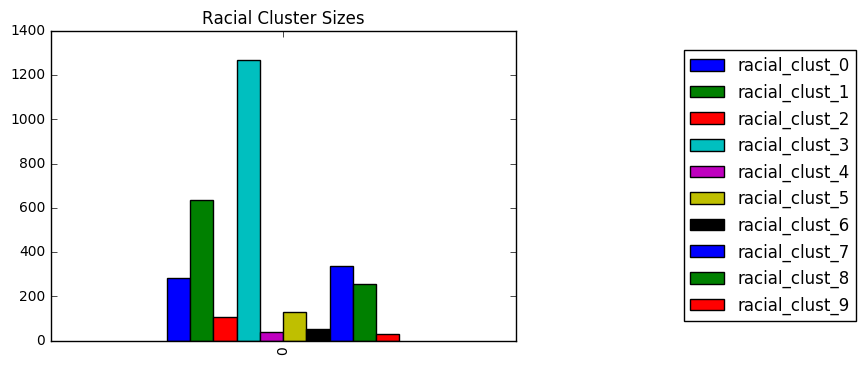

In [46]:
f = plt.figure()
race.plot(kind='bar', ax=f.gca(), title="Racial Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()


- a couple of clusters are very large while the rest are very small

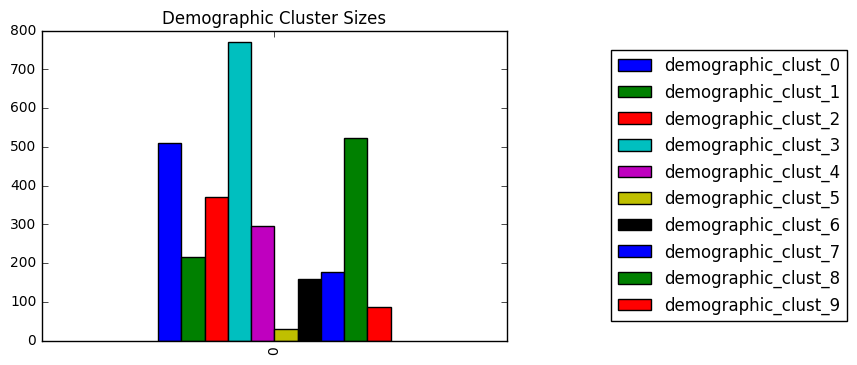

In [47]:
f2 = plt.figure()
demo.plot(kind='bar', ax=f2.gca(), title="Demographic Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()

- cluster 0 is much smaller than the rest. 

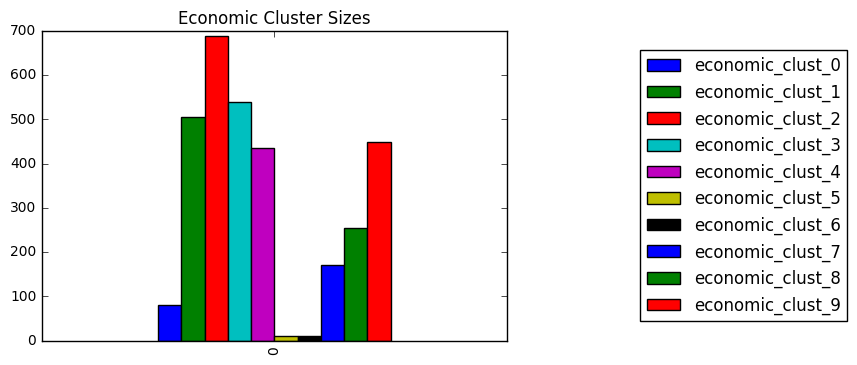

In [48]:
f3 = plt.figure()
econo.plot(kind='bar', ax=f3.gca(), title="Economic Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()

- cluster 4 seems significantly smaller than others.

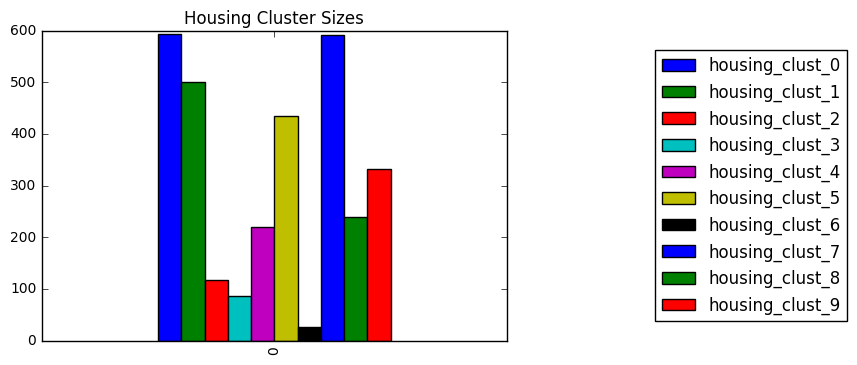

In [49]:
f4 = plt.figure()
house.plot(kind='bar', ax=f4.gca(), title="Housing Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()

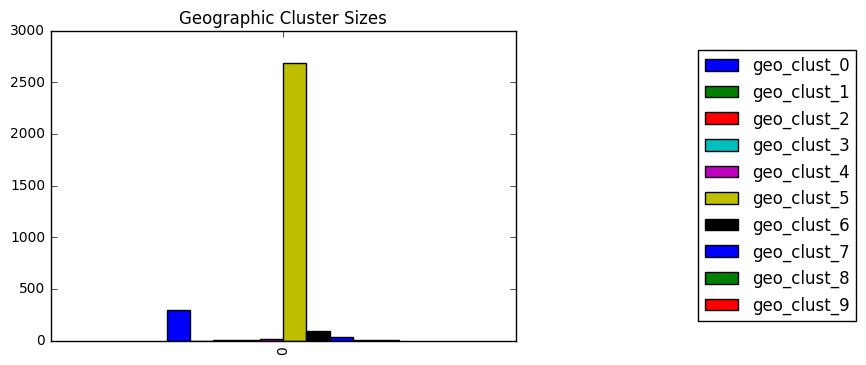

In [50]:
f5 = plt.figure()
geo.plot(kind='bar', ax=f5.gca(), title="Geographic Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()

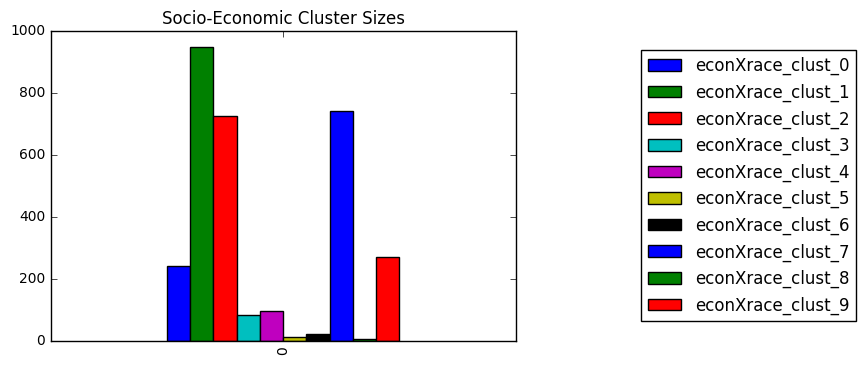

In [51]:
f6 = plt.figure()
econ_race.plot(kind='bar', ax=f6.gca(), title="Socio-Economic Cluster Sizes")
plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
plt.show()

### Take a deeper look - lets look at description of each cluster within the cluster types

In [54]:
econ_mask = econ_predictors
try1.groupby(by='demographic_clust')[county_demog_predictors].describe()

Pop%Change       Pop2014     Under5%    Under18%  \
demographic_clust                                                           
0                 count  511.000000  5.110000e+02  511.000000  511.000000   
                  mean     0.414873  5.022631e+04    6.549315   24.515068   
                  std      3.170324  6.595815e+04    0.631210    1.621772   
                  min    -17.000000  2.620000e+02    5.000000   19.400000   
                  25%     -1.400000  1.722750e+04    6.100000   23.500000   
                  50%      0.200000  3.253800e+04    6.500000   24.300000   
                  75%      2.050000  6.155750e+04    6.900000   25.500000   
                  max     17.100000  7.155970e+05    8.800000   30.200000   
1                 count  216.000000  2.160000e+02  216.000000  216.000000   
                  mean     1.025000  1.072266e+05    4.660648   19.040278   
                  std      2.603794  1.570464e+05    0.788096    2.879308   
                  min     -7.600000  0.000000e+00    0.000000    0.000000   
                  25%     -0.725000  1.757350e+04    4.300000   18.200000   
                  50%      0.700000  4.817000e+04    4.800000   19.400000   
                  75%      2.500000  1.454745e+05    5.200000   20.600000   
                  max     10.400000  9.380980e+05    6.300000   25.300000   
2                 count  371.000000  3.710000e+02  371.000000  371.000000   
                  mean     3.514555  1.884812e+05    6.428032   24.006469   
                  std      3.593779  2.082212e+05    0.659911    1.873156   
                  min     -3.200000  4.530000e+02    4.000000   18.400000   
                  25%      1.100000  4.290250e+04    6.000000   22.700000   
                  50%      2.700000  1.204600e+05    6.300000   24.000000   
                  75%      5.300000  2.479670e+05    6.900000   25.100000   
                  max     25.500000  1.091742e+06    8.300000   29.800000   
3                 count  772.000000  7.720000e+02  772.000000  772.000000   
                  mean    -0.796244  3.600748e+04    5.632902   22.105570   
                  std      2.402484  4.859886e+04    0.585409    1.567614   
                  min     -9.400000  5.040000e+02    3.500000   17.600000   
                  25%     -2.200000  8.403000e+03    5.200000   21.000000   
                  50%     -1.100000  1.920900e+04    5.600000   22.100000   
...                             ...           ...         ...         ...   
6                 std      4.066200  3.944157e+05    0.873700    3.422334   
                  min     -1.500000  7.840000e+03    3.700000   13.400000   
                  25%      3.150000  9.443050e+04    5.400000   20.150000   
                  50%      5.200000  2.607500e+05    5.900000   22.100000   
                  75%      7.700000  6.440860e+05    6.500000   24.350000   
                  max     18.000000  1.894605e+06    9.000000   29.400000   
7                 count  178.000000  1.780000e+02  178.000000  178.000000   
                  mean     0.599438  7.196210e+04    7.658989   27.219663   
                  std      4.497878  1.788715e+05    1.044898    3.032965   
                  min    -11.700000  4.000000e+02    5.600000   20.600000   
                  25%     -1.975000  1.109550e+04    6.900000   25.300000   
                  50%      0.000000  2.128300e+04    7.500000   26.900000   
                  75%      2.800000  4.130675e+04    8.300000   29.175000   
                  max     18.200000  1.438159e+06   10.600000   35.300000   
8                 count  524.000000  5.240000e+02  524.000000  524.000000   
                  mean    -1.917557  2.134046e+04    5.404962   21.112405   
                  std      2.810380  1.711594e+04    0.667874    2.089475   
                  min    -13.400000  8.050000e+02    2.800000   10.100000   
                  25%     -3.500000  1.053900e+04    5.000000   20.000000   
                  50%